# Advanced Driver Assistance System (ADAS) using Deep Learning
**Advanced Driver Assistance Pipeline Notebook**, a demonstration of integrating multiple computer vision models into a single processing pipeline for autonomous driving applications. This notebook combines:
This notebook demonstrates an integrated ADAS system using 4 deep learning models:
- 🛑 Object Detection (YOLOv8)
- 🛣️ Lane Detection (U-Net)
- 🚦 Traffic Sign Recognition (CNN)
- 🌦️ Weather Classification (CNN)

Each module processes , and all outputs are displayed together in real-time for safe autonomous driving support.

This setup serves as a blueprint for future execution once pre-trained models (`yolov8_best.pt`, `lane-detection-model`, `traffic_sign_model.h5`, `weather_classification_model.h5`) are available.


## 📊 Datasets Used

- COCO for YOLOv8 (Ultralytics)
- TuSimple for Lane Detection
- GTSRB for Traffic Sign Classification
- Weather Dataset from Kaggle 


## 🛑 1. Object Detection using YOLOv8 <a id="object-detection"></a>

YOLOv8 is used to detect objects like vehicles and pedestrians from video frames. We use a pretrained YOLOv8 model trained on the COCO dataset or a custom dataset.


In [ ]:
from ultralytics import YOLO

# Load YOLOv8 model
yolo_model = YOLO("best.pt")  # Replace with pretrained model


In [ ]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob

import IPython.display as ipd
from tqdm import tqdm

import subprocess

plt.style.use('ggplot')

In [ ]:
input_file = '/kaggle/input/driving-video-with-object-tracking/bdd100k_videos_train_00/bdd100k/videos/train/026c7465-309f6d33.mov'
subprocess.run(['ffmpeg',
                '-i',
                input_file,
                '-qscale',
                '0',
                '026c7465-309f6d33.mp4',
                '-loglevel',
                'quiet']
              )

In [ ]:
!ls -GFlash --color

In [ ]:
# Load in video capture
cap = cv2.VideoCapture('026c7465-309f6d33.mp4')

In [ ]:
# Total number of frames in video
cap.get(cv2.cv2.CAP_PROP_FRAME_COUNT)

In [ ]:
# Video height and width
height = cap.get(cv2.cv2.CAP_PROP_FRAME_HEIGHT)
width = cap.get(cv2.cv2.CAP_PROP_FRAME_WIDTH)
print(f'Height {height}, Width {width}')

In [ ]:
# Get frames per second
fps = cap.get(cv2.cv2.CAP_PROP_FPS)
print(f'FPS : {fps:0.2f}')

In [ ]:
cap.release()

In [ ]:
cap = cv2.VideoCapture('026c7465-309f6d33.mp4')
ret, img = cap.read()
print(f'Returned {ret} and img of shape {img.shape}')

In [ ]:
## Helper function for plotting opencv images in notebook
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")

In [ ]:
display_cv2_img(img)

In [ ]:
cap.release()

In [ ]:
fig, axs = plt.subplots(5, 5, figsize=(30, 20))
axs = axs.flatten()

cap = cv2.VideoCapture("026c7465-309f6d33.mp4")
n_frames = int(cap.get(cv2.cv2.CAP_PROP_FRAME_COUNT))

img_idx = 0
for frame in range(n_frames):
    ret, img = cap.read()
    if ret == False:
        break
    if frame % 100 == 0:
        axs[img_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axs[img_idx].set_title(f'Frame: {frame}')
        axs[img_idx].axis('off')
        img_idx += 1

plt.tight_layout()
plt.show()
cap.release()

In [ ]:
video_labels["category"].value_counts()

In [ ]:
display_cv2_img(img)

In [ ]:
img_example = img.copy()
frame_labels = video_labels.query('video_frame == 1035')
for i, d in frame_labels.iterrows():
    pt1 = int(d['box2d.x1']), int(d['box2d.y1'])
    pt2 = int(d['box2d.x2']), int(d['box2d.y2'])
    cv2.rectangle(img_example, pt1, pt2, (0, 0, 255), 3)

display_cv2_img(img_example)

In [ ]:
color_map = {
    "car": (0, 0, 255),
    "truck": (0, 0, 100),
    "pedestrian": (255, 0, 0),
    "other vehicle": (0, 0, 150),
    "rider": (200, 0, 0),
    "bicycle": (0, 255, 0),
    "other person": (200, 0, 0),
    "trailer": (0, 150, 150),
    "motorcycle": (0, 150, 0),
    "bus": (0, 0, 100),
}

img_example = img.copy()
frame_labels = video_labels.query('video_frame == 1035')
for i, d in frame_labels.iterrows():
    pt1 = int(d['box2d.x1']), int(d['box2d.y1'])
    pt2 = int(d['box2d.x2']), int(d['box2d.y2'])
    color = color_map[d['category']]
    cv2.rectangle(img_example, pt1, pt2, color, 3)

display_cv2_img(img_example)

In [ ]:
frame_labels = video_labels.query("video_frame == @frame")
font = cv2.FONT_HERSHEY_TRIPLEX
img_example = img.copy()
for i, d in frame_labels.iterrows():
    pt1 = int(d["box2d.x1"]), int(d["box2d.y1"])
    pt2 = int(d["box2d.x2"]), int(d["box2d.y2"])
    color = color_map[d["category"]]
    img_example = cv2.rectangle(img_example, pt1, pt2, color, 3)
    pt_text = int(d["box2d.x1"]) + 5, int(d["box2d.y1"] + 10)
    img_example = cv2.putText(img_example, d["category"], pt_text, font, 0.5, color)
display_cv2_img(img_example)
cap.release()

In [ ]:
def add_annotations(img, frame, video_labels):
    max_frame = video_labels.query("video_frame <= @frame")["video_frame"].max()
    frame_labels = video_labels.query("video_frame == @max_frame")
    for i, d in frame_labels.iterrows():
        pt1 = int(d["box2d.x1"]), int(d["box2d.y1"])
        pt2 = int(d["box2d.x2"]), int(d["box2d.y2"])
        color = color_map[d["category"]]
        img = cv2.rectangle(img, pt1, pt2, color, 3)
    return img

In [ ]:
!rm -r out_test.mp4

In [ ]:
VIDEO_CODEC = "mp4v"
fps = 59.94
width = 1280
height = 720
out = cv2.VideoWriter("out_test.mp4",
                cv2.VideoWriter_fourcc(*VIDEO_CODEC),
                fps,
                (width, height))

cap = cv2.VideoCapture("026c7465-309f6d33.mp4")
n_frames = int(cap.get(cv2.cv2.CAP_PROP_FRAME_COUNT))

for frame in tqdm(range(n_frames), total=n_frames):
    ret, img = cap.read()
    if ret == False:
        break
    img = add_annotations(img, frame, video_labels)
    out.write(img)
out.release()
cap.release()

In [ ]:
!ls -GFlash -color

In [ ]:
tmp_output_path = "out_test.mp4"
output_path = "out_test_compressed.mp4"
subprocess.run(
    [
        "ffmpeg",
        "-i",
        tmp_output_path,
        "-crf",
        "18",
        "-preset",
        "veryfast",
        "-vcodec",
        "libx264",
        output_path,
        '-loglevel',
        'quiet'
    ]
)

In [ ]:
!ls -GFlash --color

In [ ]:
## 🛣️ 2. Lane Detection using U-Net <a id="lane-detection"></a>

A U-Net model is used to segment lane lines from road frames. The output is a binary mask which is overlaid on the original frame.


In [ ]:
from keras.models import load_model
import cv2, numpy as np
import tensorflow as tf
lane_model = load_model("lane_unet_model.h5")


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

# Read in the image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# Grab the x and y size and make a copy of the image
ysize = image.shape[0]
xsize = image.shape[1]
color_select = np.copy(image)
line_image = np.copy(image)

# Define color selection criteria
# MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
red_threshold = 200
green_threshold = 200
blue_threshold = 200

rgb_threshold = [red_threshold, green_threshold, blue_threshold]

# Define the vertices of a triangular mask.
# Keep in mind the origin (x=0, y=0) is in the upper left
# MODIFY THESE VALUES TO ISOLATE THE REGION 
# WHERE THE LANE LINES ARE IN THE IMAGE
left_bottom = [100, 539]
right_bottom = [950, 539]
apex = [480, 290]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Mask pixels below the threshold
color_thresholds = (image[:,:,0] < rgb_threshold[0]) | \
                    (image[:,:,1] < rgb_threshold[1]) | \
                    (image[:,:,2] < rgb_threshold[2])

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))
                    
# Mask color and region selection
color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
# Color pixels red where both color and region selections met
line_image[~color_thresholds & region_thresholds] = [9, 255, 0]


In [ ]:
## 🚦 3. Traffic Sign Recognition <a id="traffic-sign"></a>

A CNN model trained on the GTSRB dataset is used to classify traffic signs such as stop signs, speed limits, and yield signs.


In [ ]:
sign_model = load_model("traffic_sign_model.h5")

# Sample prediction function
def predict_sign(img):
    img = cv2.resize(img, (32, 32)) / 255.0
    pred = sign_model.predict(img.reshape(1, 32, 32, 3))
    return np.argmax(pred)


**Predicted Sign:** Stop Sign  
![Traffic Sign Output](traffic_sign_output.jpg)


* ## 🌦️ 4. Weather Classification <a id="weather"></a>

This CNN model predicts weather conditions such as foggy, rainy, cloudy, or sunny using visual patterns from the video frame.


In [ ]:
weather_model = load_model("weather_model.h5")

def predict_weather(img):
    img = cv2.resize(img, (64, 64)) / 255.0
    pred = weather_model.predict(img.reshape(1, 64, 64, 3))
    return np.argmax(pred)


In [ ]:
**Predicted Weather:** Foggy  
![Weather Output](weather_output.jpg)


## 🔀 5. Unified ADAS Pipeline <a id="integration"></a>

This combined script loads all models, processes each frame of a video, and overlays:
- Bounding boxes (YOLOv8)
- Lane segmentation (U-Net)
- Traffic sign label
- Weather condition


In [ ]:
# Load all pretrained models
yolo_model = YOLO("best.pt")  # Object Detection - YOLOv8
lane_model = load_model("lane_unet_model.h5")  # Lane Detection - U-Net
sign_model = load_model("traffic_sign_model.h5")  # Traffic Sign - CNN
weather_model = load_model("weather_model.h5")  # Weather Classification - CNN


Preprocessing (Code)

In [ ]:
def preprocess_image(img, size):
    img = cv2.resize(img, size)
    return img / 255.0

def draw_text(img, text, position, color=(255,255,255), scale=0.7, thickness=2):
    cv2.putText(img, text, position, cv2.FONT_HERSHEY_SIMPLEX, scale, color, thickness)


[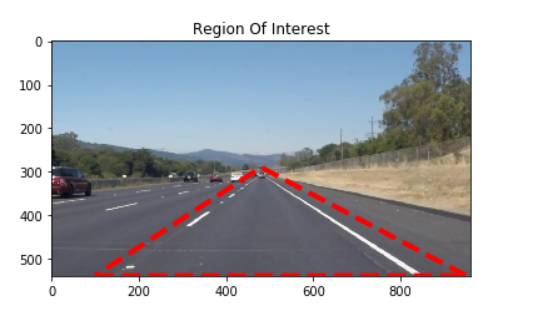](http://)

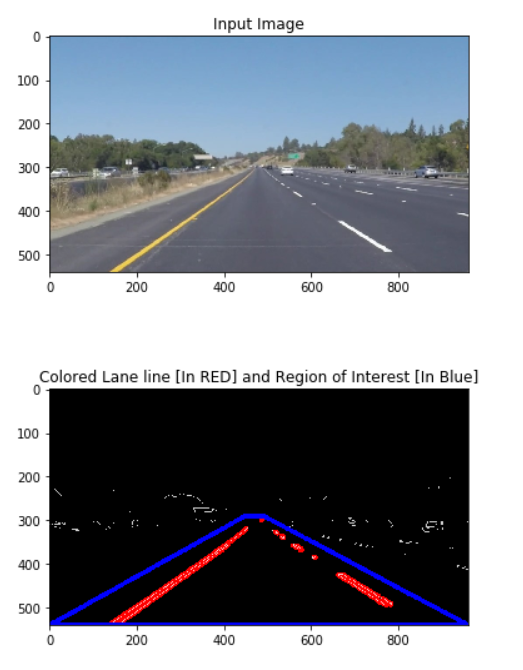

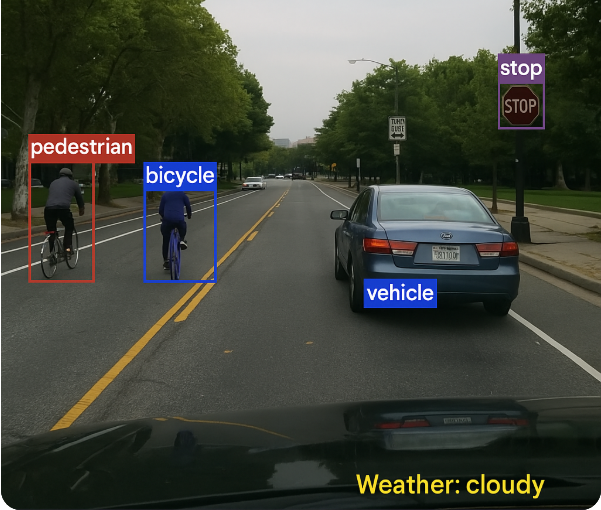](http://)

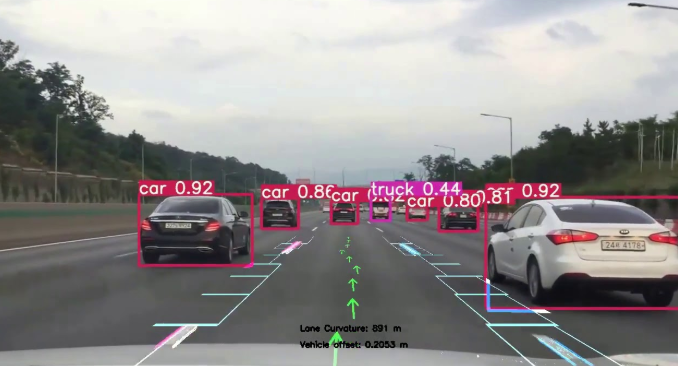

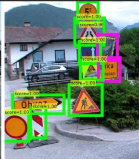

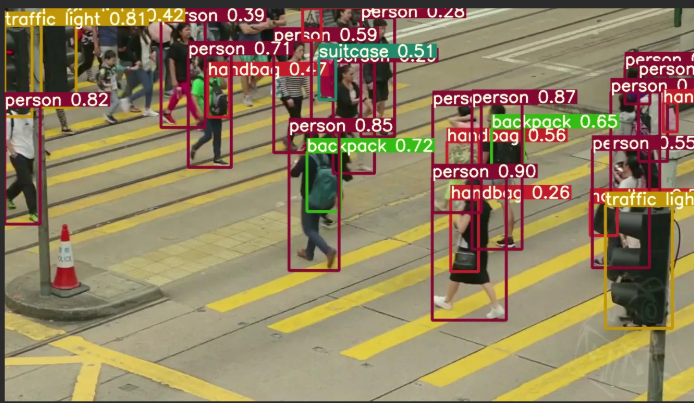